In [1]:
import numpy as np
import matplotlib.pylab as plt

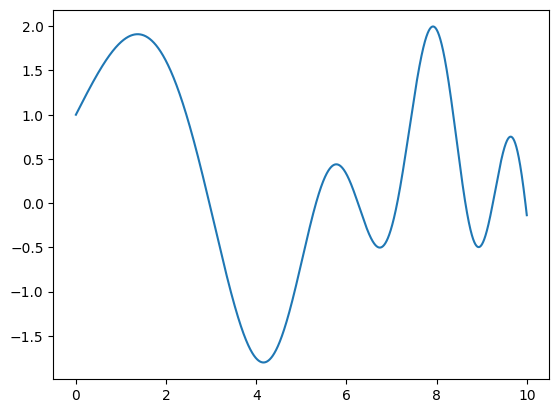

In [2]:
import random
random.seed(42)

xs = np.linspace(0, 10, 10000)
ys = np.sin(xs) + np.cos(0.2* xs**2)
# for i in range(0, 10000, 100):
#     ys[i] += random.random() - 0.5

plt.plot(xs, ys);

In [3]:
from sklearn.tree import DecisionTreeRegressor

pred_sofar = np.zeros_like(ys)
X = xs.reshape(-1, 1)

def update(pred_sofar):
    plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.plot(xs, ys, label="orig")
    plt.plot(xs, pred_sofar, label="pred")
    plt.legend()

    err_sofar = pred_sofar - ys
    
    plt.subplot(132)
    plt.ylim(ys.min() - 0.3, ys.max())
    plt.plot(xs, err_sofar)
    plt.title("error sofar")
    
    new_model = DecisionTreeRegressor(max_depth=3)
    new_model.fit(X, ys - pred_sofar)
    new_preds = new_model.predict(X)
    pred_sofar += new_preds

    plt.subplot(133)
    plt.plot(xs, new_preds)
    plt.ylim(ys.min() - 0.3, ys.max())
    plt.title("local correction")
    return pred_sofar


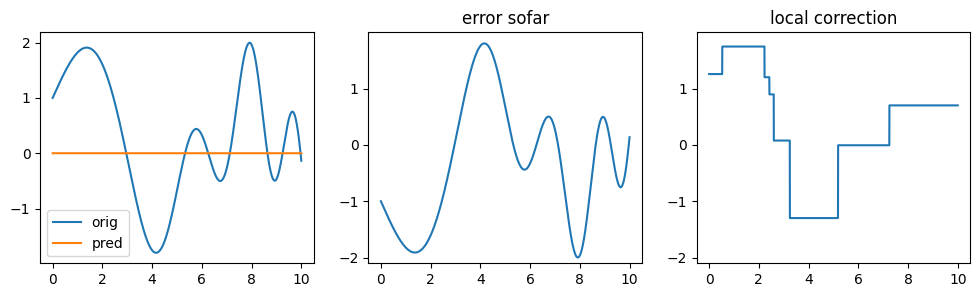

In [4]:
pred_sofar = update(pred_sofar)

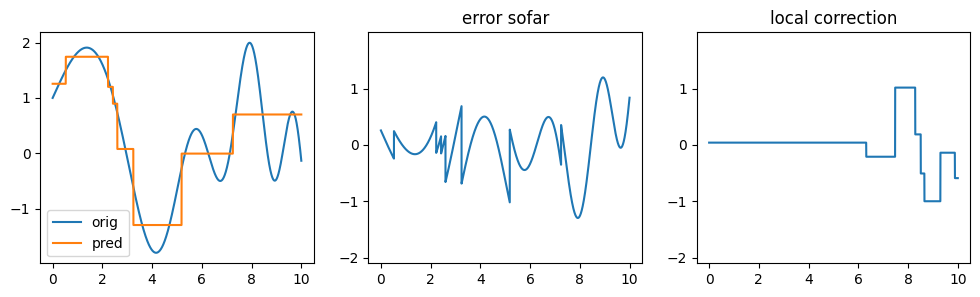

In [5]:
pred_sofar = update(pred_sofar)

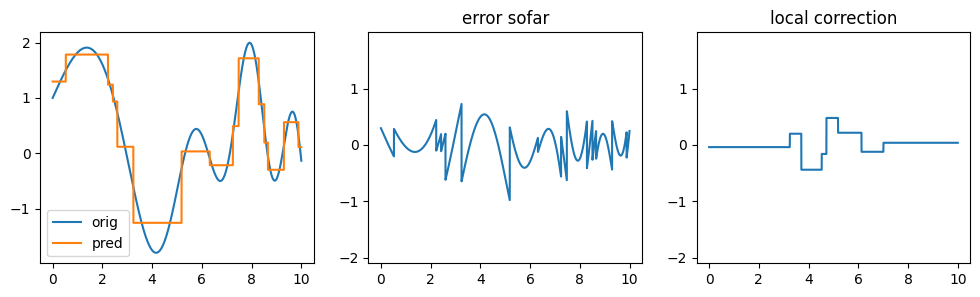

In [6]:
pred_sofar = update(pred_sofar)

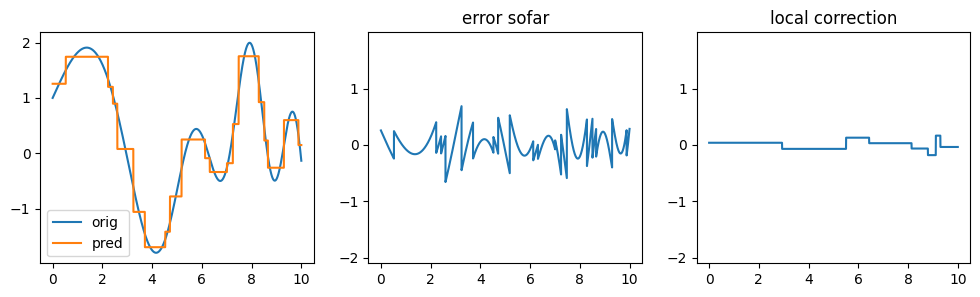

In [7]:
pred_sofar = update(pred_sofar)

In [8]:
from ipywidgets import interact

@interact(split=(xs.min()+0.001, xs.max(), 0.01))
def f(split):
    plt.figure(figsize=(12, 3))
    plt.plot(xs, ys, label="orig")
    plt.axvline(split, color="black", linestyle="--")
    pred = np.where(xs < split, ys[xs < split].mean(), ys[xs >= split].mean())
    plt.plot(xs, pred, label="pred")
    plt.legend()
    plt.title(f"err = {np.mean((pred - ys)**2)}")


interactive(children=(FloatSlider(value=4.9910000000000005, description='split', max=10.0, min=0.001, step=0.0…

In [9]:
def sliding(arr):
    for i, val in enumerate(arr):
        if i != len(arr) - 1:
            yield arr[i], arr[i+1]
        

In order for the below cells to run, you're gonna want to run the 2nd cell first. It's annoying, I know, but it's a better layout this way.

In [15]:
import ipywidgets

cuts = []
btn = ipywidgets.Button(description="make the cut")

def onclick(event):
    cuts.append(f.widget.children[0].value)

btn.on_click(onclick)

btn

Button(description='make the cut', style=ButtonStyle())

In [16]:
@interact(p=(xs.min()+0.001, xs.max(), 0.01))
def f(p):
    global cuts
    plt.figure(figsize=(12, 3))
    plt.plot(xs, ys, label="orig")
    plt.axvline(p, color="black", linestyle="--")
    cuts_new = sorted([0] + [p] + cuts)
    pred = np.zeros_like(ys)
    for lower, upper in sliding(cuts_new):
        x_lower = np.argmin((xs - lower) ** 2)
        x_upper = np.argmin((xs - upper) ** 2)
        pred[x_lower:x_upper] = ys[x_lower:x_upper].mean()
    plt.plot(xs, pred, label="pred")
    plt.legend()
    plt.title(f"err = {np.mean((pred - ys)**2)}")

interactive(children=(FloatSlider(value=4.9910000000000005, description='p', max=10.0, min=0.001, step=0.01), …

In [73]:
import time 
import tqdm
from sklearn.datasets import make_classification
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

results = []

for size in tqdm.tqdm([500, 1_000, 5_000, 10_000, 20_000, 50_000]):
    X, y = make_classification(random_state=42, n_samples=size)
    for method in [HistGradientBoostingRegressor, GradientBoostingRegressor]:
        tic = time.time()
        score = cross_val_score(method(), X=X, y=y, n_jobs=-1).mean()
        toc = time.time()
        results.append({
            "size": size,
            "method": method().__class__.__name__,
            "score": score,
            "time": toc - tic
        })

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:52<00:00,  8.70s/it]


In [74]:
import altair as alt 
import polars as pl

p1 = (alt.Chart(pl.DataFrame(results))
  .mark_line()
  .ecnode(x=alt.X('size').scale(type="log"), y='time', color="method")
  .properties(width=600, height=150))

p2 = (alt.Chart(pl.DataFrame(results))
  .mark_line()
  .encode(x=alt.X('size').scale(type="log"), y='score', color="method")
  .properties(width=600, height=150))

(p1 & p2).interactive()

alt.VConcatChart(...)